# 합성곱 신경망의 구성 요소

## 합성곱
- CNN(Convolutional Neural Network, 합성곱 신경망)에서 이미지나 데이터를 처리할 때 특징을 추출하는 연산
- 뉴런을 필터(filter, 개수를 표현할 때 사용) 또는 커널(kernel, 입력에 곱하는 가중치)이라고 부름
- **특성 맵**: feature map, 합성곱 계산을 통해 얻은 출력

## 케라스 합성곱 층
```python
import keras
keras.layers.Conv2D(n, kernel_size=(m,m), activation='relu')
```
- n: 필터의 개수
- kernel_size: 커널의 크기
- activation: 활성화 함수

### 패딩 & 스트라이드
```python
keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same', strides=1)
```
- 패딩: 입력 이미지 가장자리에 0을 덧붙이는 것. 가장자리 정보도 잘 반영함
    - same padding: 입력과 특성 맵의 크기를 동일하게 만들기 위해 입력 주위에 0으로 패딩하는 것. 일반적인 합성곱 신경망에서 많이 사용
    - valid padding: 패딩 없이 순수한 입력 배열에서만 합성곱을 하여 특성 맵을 만드는 경우. 패딩의 기본값
- 스트라이드: 필터를 몇 칸씩 이동시키는지 정하는 값. 크기 조절 및 연산 속도 조절

### 풀링
```python
keras.layers.MaxPooling2D(2, strides=2, padding='valid')
```
```python
keras.layers.AveragePooling2D(2)
```
- 첫번째 매개변수는 풀링의 크기, 보통 2로 지정
- strides의 기본값은 자동으로 풀링의 크기를 따라가므로 지정할 필요 X
- 풀링: 특성 맵(Feature Map)의 크기를 줄이면서 중요한 정보만 추출하는 연산.
주로 CNN에서 과적합 방지와 연산량 감소를 위해 사용됨
    - 최대 풀링(Max Pooling): 각 영역에서 최댓값만 추출. 가장 많이 사용됨
    - 평균 풀링(Average Pooling): 각 영역의 평균값을 추출

# 합성곱 신경망을 사용한 이미지 분류

## 패션 MNIST 데이터 불러오기

In [2]:
import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0  # 흑백 이미지(2차원)이므로 3차원으로 변환
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

## 합성곱 신경망 만들기

In [3]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28,28,1)))
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

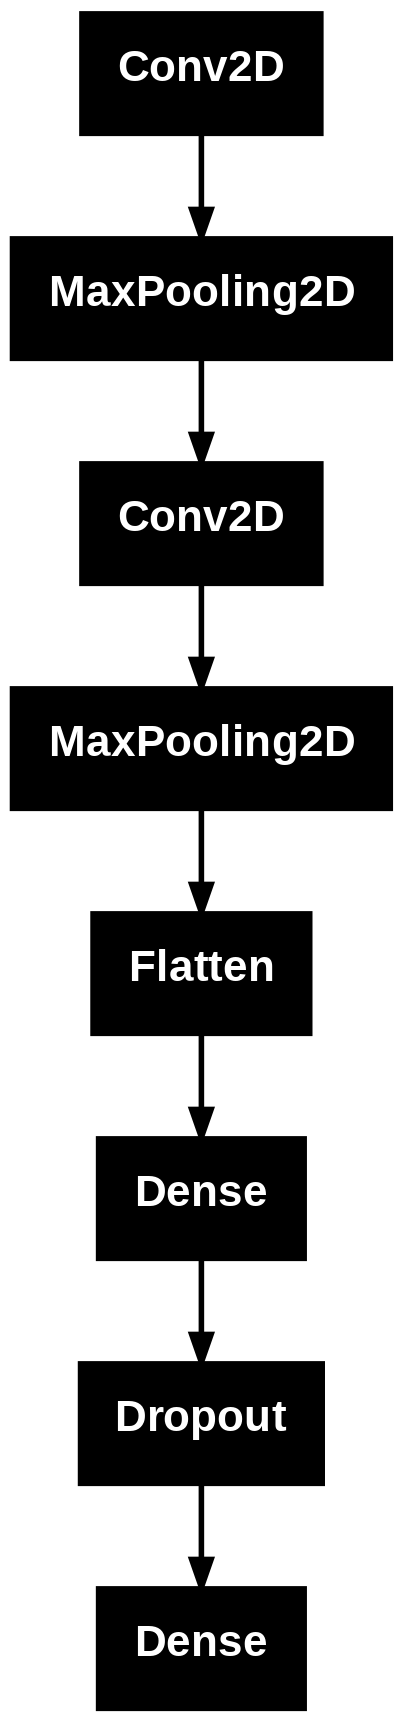

In [5]:
keras.utils.plot_model(model)

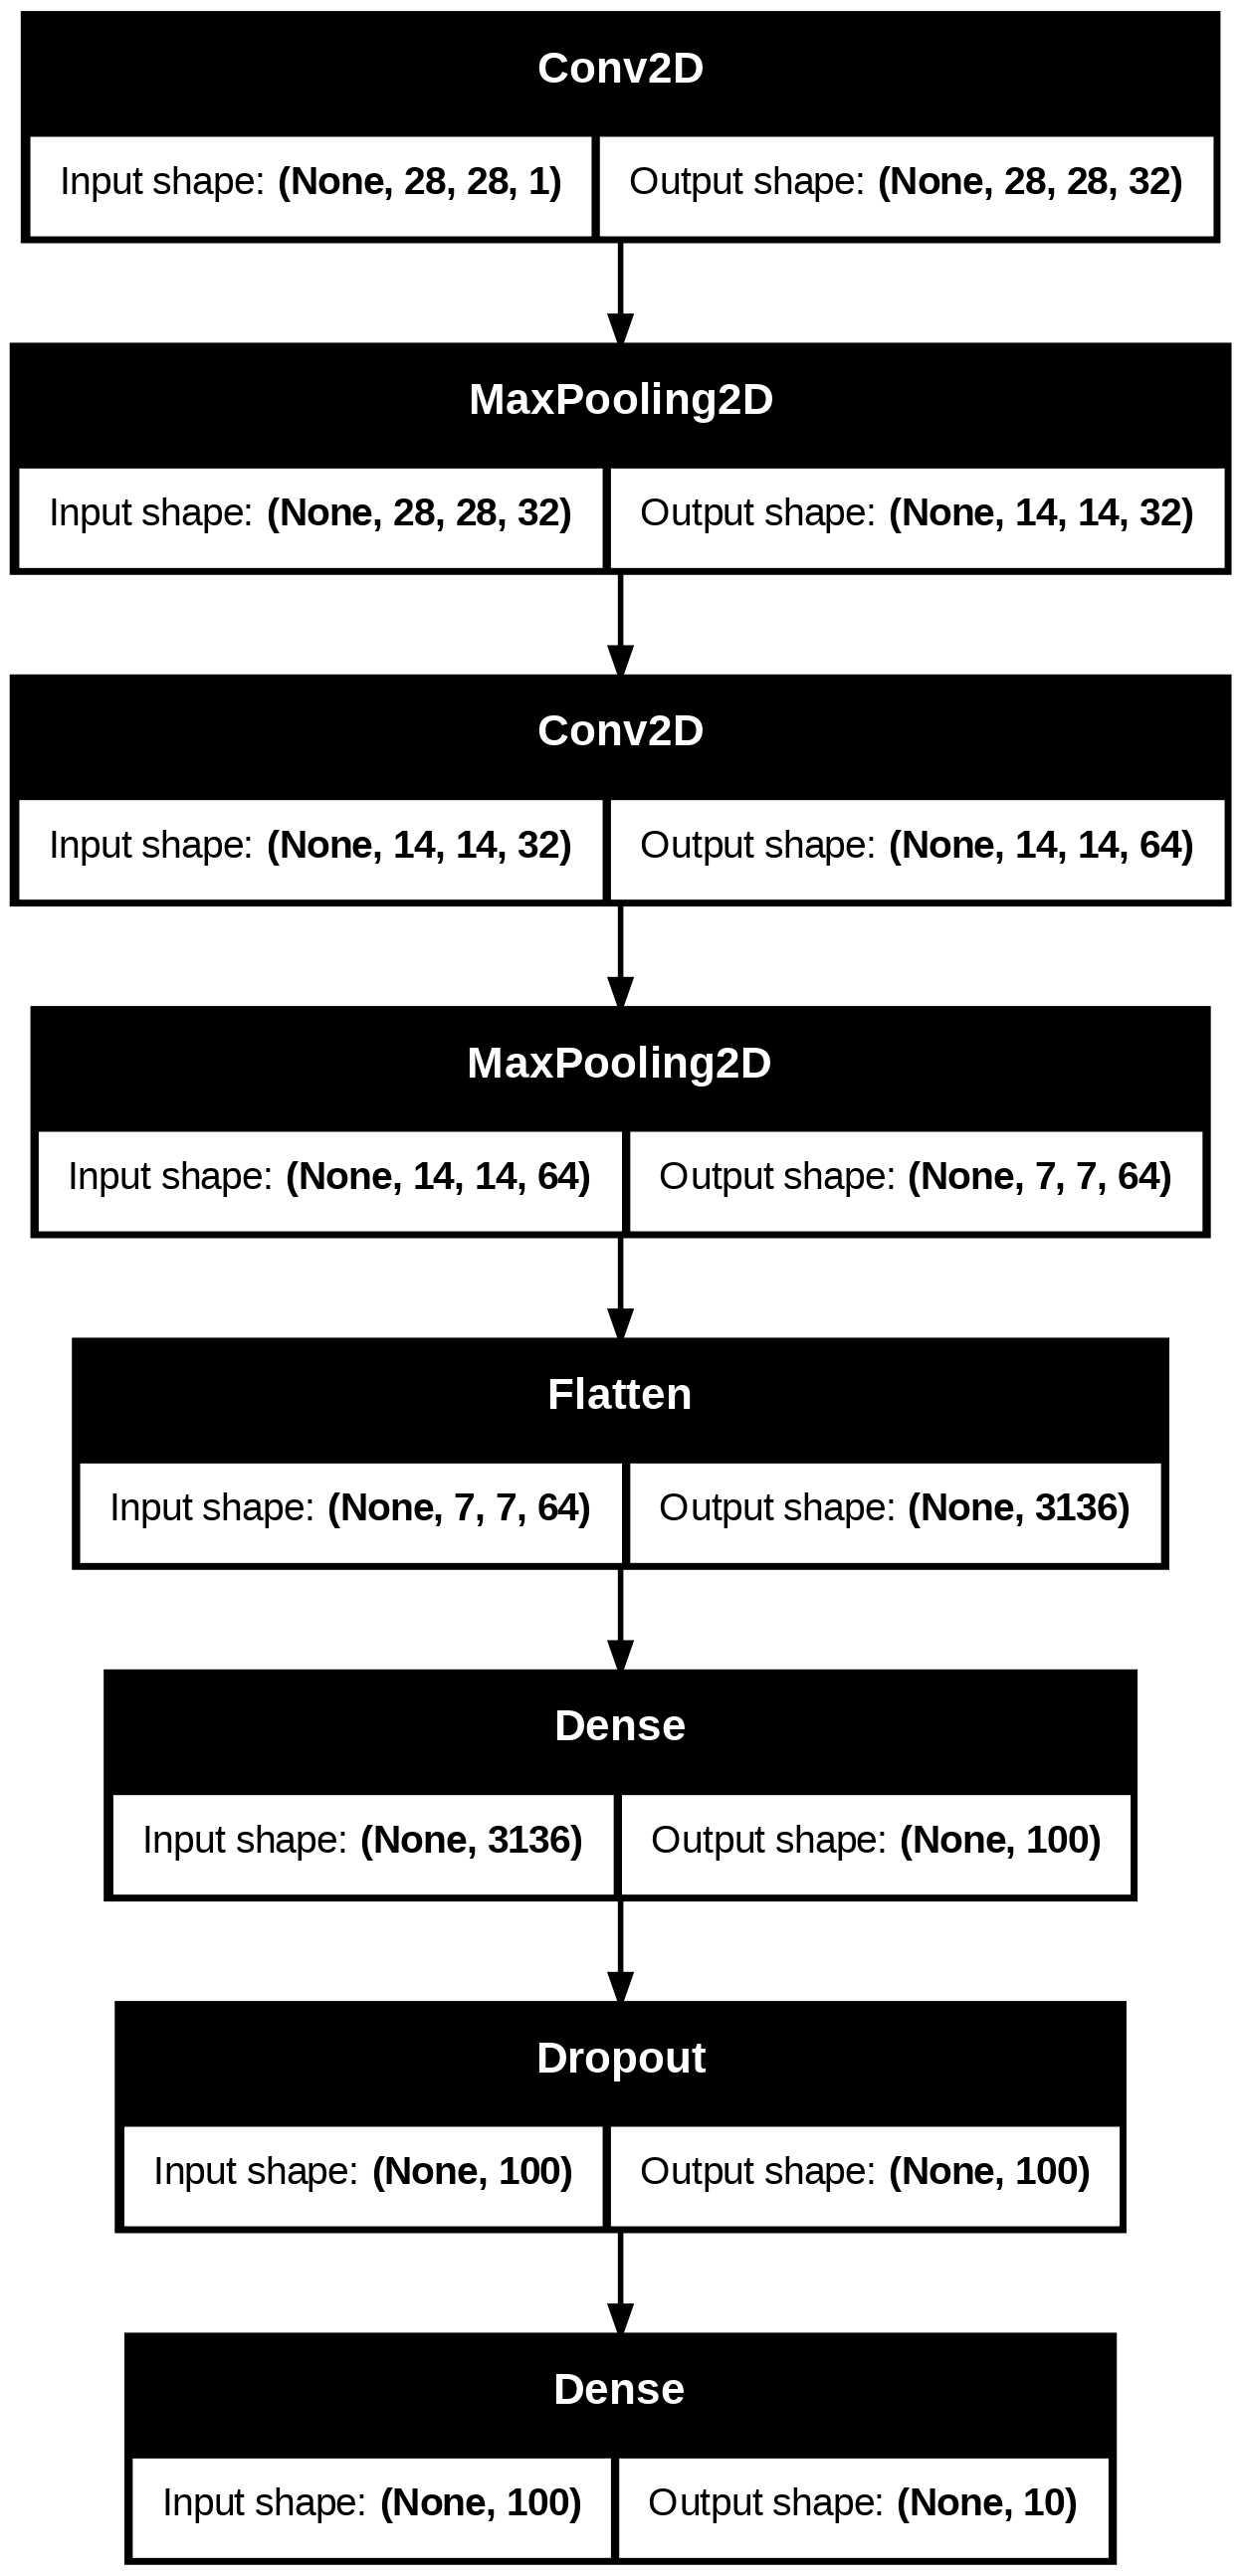

In [6]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(
    train_scaled,
    train_target,
    epochs=20,
    validation_data=(val_scaled, val_target),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7289 - loss: 0.7493 - val_accuracy: 0.8795 - val_loss: 0.3271
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8710 - loss: 0.3666 - val_accuracy: 0.8930 - val_loss: 0.2845
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8887 - loss: 0.3104 - val_accuracy: 0.9056 - val_loss: 0.2559
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9037 - loss: 0.2701 - val_accuracy: 0.9112 - val_loss: 0.2403
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9110 - loss: 0.2486 - val_accuracy: 0.9160 - val_loss: 0.2269
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9186 - loss: 0.2251 - val_accuracy: 0.9137 - val_loss: 0.2373
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9236 - loss: 0.2025 - val_accuracy: 0.9184 - val_loss: 0.2270


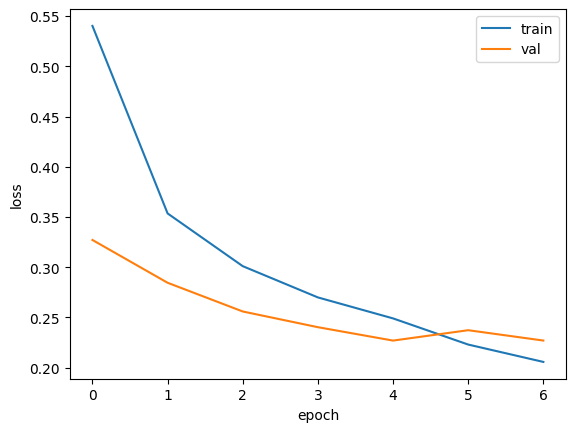

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [9]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9183 - loss: 0.2164


[0.22694863379001617, 0.9160000085830688]

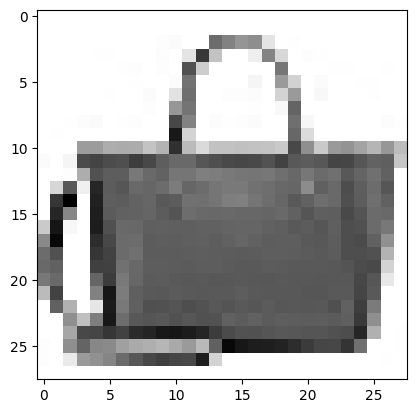

In [10]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')  # matplotlib에서는 흑백 이미지에 깊이 차원은 없음 -> reshape
plt.show()

In [11]:
preds = model.predict(val_scaled[0:1])  # 케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대 -> 슬라이싱 필요
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
[[1.7640270e-17 2.4108440e-25 8.2389526e-19 7.2238515e-19 2.9656950e-17
  9.5813191e-15 4.1139138e-16 1.2621946e-17 1.0000000e+00 4.1898696e-17]]


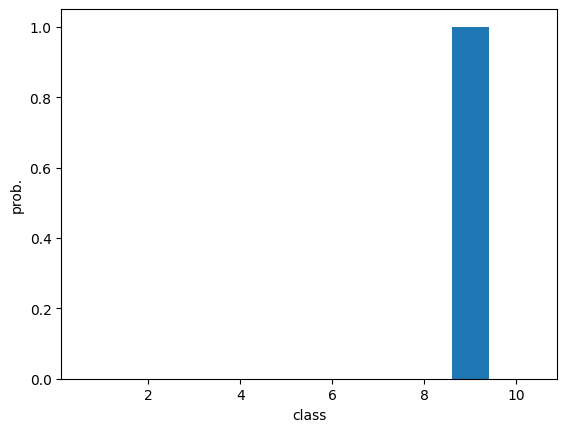

In [12]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [13]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [14]:
import numpy as np

print(classes[np.argmax(preds)])

가방


In [15]:
test_scaled = test_input.reshape(-1,  28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9133 - loss: 0.2551


[0.25024911761283875, 0.9114000201225281]

## Pytorch

In [16]:
# Pytorch에서는 (28,28) -> (1,28,28)

from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input.reshape(-1, 1, 28, 28) / 255.0

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 195kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.63MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]


In [17]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [18]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1, 32, kernel_size=3, padding='same'))  # 입력 채널 개수, 출력 채널 개수, 커널 사이즈, 패딩
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())

In [19]:
# Linear 층을 사용할 때는 입력 크기를 첫 번째 매개변수로 전달해야 함 -> 가짜 입력을 만들어 출력 확인
import torch

outputs = model(torch.ones(1, 1, 28, 28))
print(outputs.shape)

torch.Size([1, 3136])


In [20]:
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('droput', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100, 10))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3136, out_features=100, bias=True)
  (relu3): ReLU()
  (droput): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=100, out_features=10, bias=True)
)

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류
optimizer = optim.Adam(model.parameters())

In [23]:
# tensorflow에서는 에포크마다 훈련 세트를 섞지 않았음 -> TensorDataset과 DataLoader를 통해 해결
# TensorDataset: 여러 텐서(다차원 배열)를 결합하여 하나의 데이터셋으로 관리하도록 도와줌. 데이터를 섞을 때 입력과 타깃이 같은 순서로 섞여야 하므로 배치를 만들기 전에 TensorDataset으로 입력과 타깃을 묶어 주는 것이 좋음
# DataLoader: TensorDataset으로 만든 데이터셋으로 배치를 생성. 배치 크기와 데이터를 섞을지 여부 결정

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_scaled, train_target)
val_dataset = TensorDataset(val_scaled, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # 검증 세트는 모델을 훈련하는데 사용하는 것이 아니므로 섞지 않음

In [24]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    train_loss = train_loss/len(train_loader)  # 누적된 훈련 손실은 배치 횟수로 나눔 -> 평균 훈련 손실
    val_loss = val_loss/len(val_loader)        # 누적된 검증 손실은 배치 횟수로 나눔 -> 평균 검증 손실
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},", f"훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_cnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크엥서 조기 종료되었습니다.")
            break

에포크:1, 훈련 손실:0.5012, 검증 손실:0.3453
에포크:2, 훈련 손실:0.3290, 검증 손실:0.2883
에포크:3, 훈련 손실:0.2791, 검증 손실:0.2547
에포크:4, 훈련 손실:0.2487, 검증 손실:0.2320
에포크:5, 훈련 손실:0.2249, 검증 손실:0.2378
에포크:6, 훈련 손실:0.2010, 검증 손실:0.2258
에포크:7, 훈련 손실:0.1867, 검증 손실:0.2280
에포크:8, 훈련 손실:0.1696, 검증 손실:0.2159
에포크:9, 훈련 손실:0.1539, 검증 손실:0.2346
에포크:10, 훈련 손실:0.1428, 검증 손실:0.2357
10번째 에포크엥서 조기 종료되었습니다.


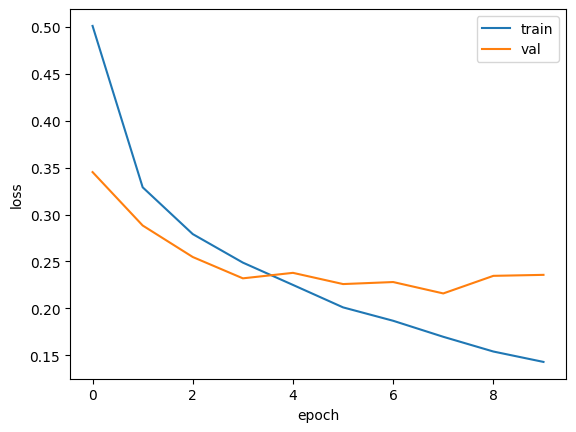

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
model.load_state_dict(torch.load('best_cnn_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        corrects += (predicts == targets).sum().item()
accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.9216


In [27]:
test_scaled = fm_test.data.reshape(-1, 1, 28, 28) / 255.0
test_target = fm_test.targets

test_dataset = TensorDataset(test_scaled, test_target)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(test_dataset)
print(f"테스트 정확도: {accuracy:.4f}")

테스트 정확도: 0.9134


# 합성곱 신경망의 시각화

## 가중치 시각화

In [29]:
# 모델이 어떤 가중치를 학습했는지 확인
import keras
model = keras.models.load_model('best-cnn-model.keras')
model.layers  # 케라스 모델에 추가한 층은 layers 속성에 저장되어 있음

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [30]:
# 첫 번째 합성곱 층의 가중치와 절편의 크기 확인
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [31]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.02650507 0.23054458


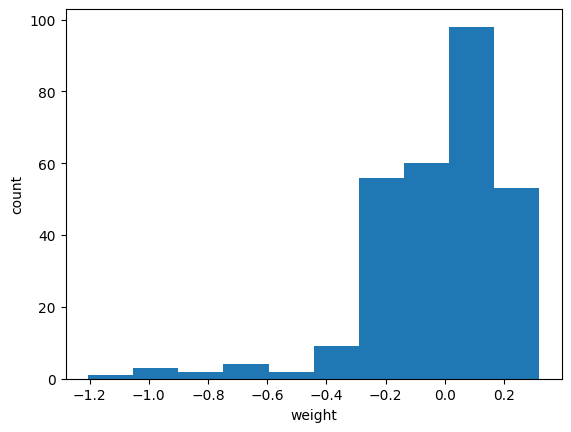

In [32]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))  # 히스토그램을 그리기 위해서는 1차원 배열 필요
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

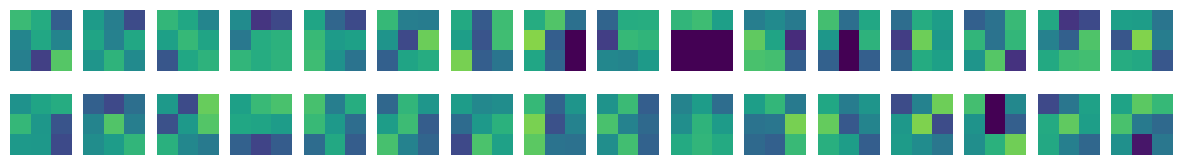

In [33]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

In [34]:
# 훈련하지 않은 빈 합성곱 신경망 -> 학습되지 않은 랜덤한 초기값
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Input(shape=(28, 28, 1)))
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))

no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [35]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.00065279275 0.08008758


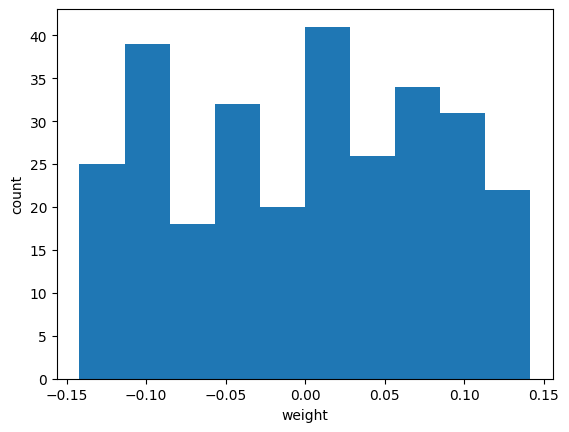

In [36]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

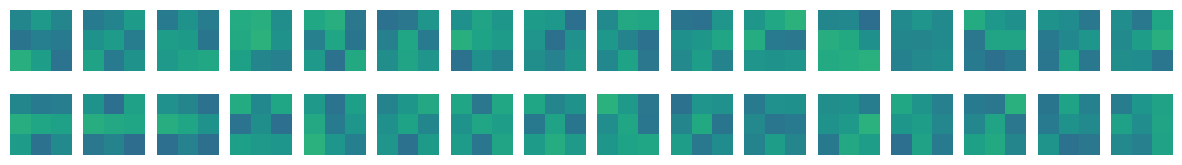

In [37]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

## 함수형 API
- 함수형 API는 케라스의 Model 클래스를 사용하여 만듦
```python
inputs = keras.Input(shape=(784,))
dense1 = keras.layers.Dense(100, activation='relu')
dense2 = keras.layers.Dense(10, activation='softmax')
```
```python
hidden = dense1(inputs)
outputs = dense2(hidden)
func_model = keras.Model(inputs, outputs)
```
- 특성 맵 시각화를 만드려면 전 과정이 필요한 것이 아니라 **특성 맵**만 있으면 됨

In [38]:
print(model.inputs)

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=input_layer>]


In [39]:
# 첫 번째 층의 입력과 출력만으로 모델 생성
conv_acti = keras.Model(model.inputs, model.layers[0].output)

## 특성 맵 시각화

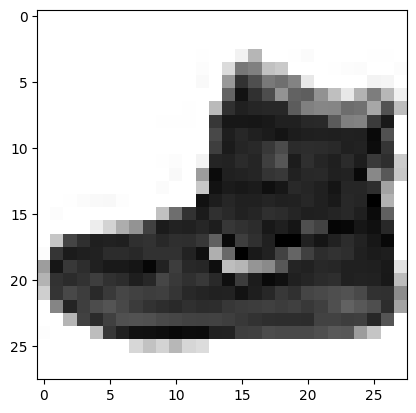

In [40]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [41]:
# conv_acti 모델에 입력하여 Conv2D 층이 만드는 특성 맵 출력
ankle_boot = train_input[0:1].reshape(1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(ankle_boot)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
(1, 28, 28, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


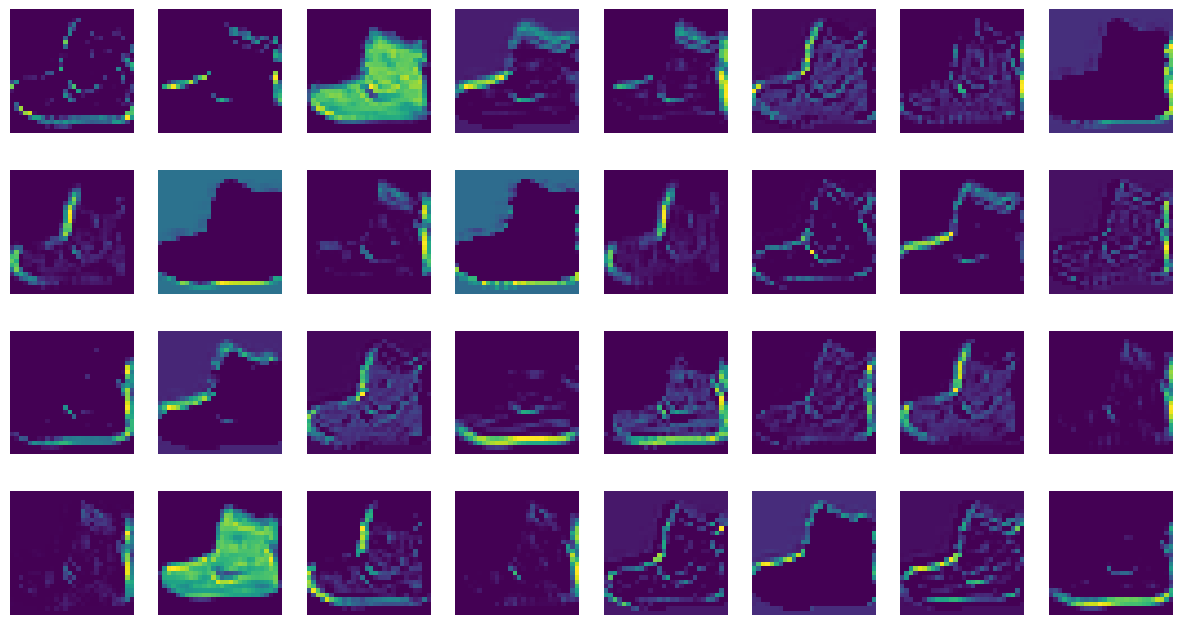

In [42]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i, j].axis('off')
plt.show()

In [43]:
conv2_acti = keras.Model(model.inputs, model.layers[2].output)
ankle_boot = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(ankle_boot)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
(1, 14, 14, 64)


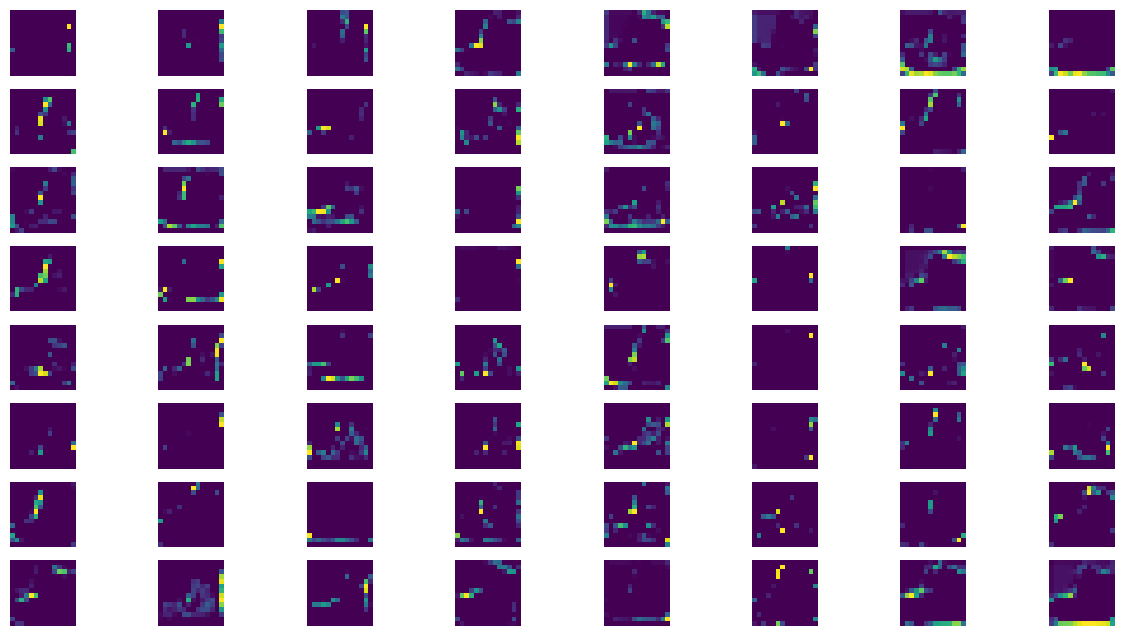

In [44]:
# 뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습
fig, axs = plt.subplots(8, 8, figsize=(15,8))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i, j].axis('off')
plt.show()

## Pytorch

In [45]:
!wget https://bit.ly/3DQeEH8 -O best_cnn_model.pt

--2025-06-05 10:02:07--  https://bit.ly/3DQeEH8
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl2/raw/refs/heads/main/best_cnn_model.pt [following]
--2025-06-05 10:02:07--  https://github.com/rickiepark/hg-mldl2/raw/refs/heads/main/best_cnn_model.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl2/refs/heads/main/best_cnn_model.pt [following]
--2025-06-05 10:02:07--  https://raw.githubusercontent.com/rickiepark/hg-mldl2/refs/heads/main/best_cnn_model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [46]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1, 32, kernel_size=3, padding='same'))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100,10))

In [47]:
import torch

model.load_state_dict(torch.load('best_cnn_model.pt', weights_only=True))

<All keys matched successfully>

In [48]:
# 모델의 층을 참조하는 방법 #1
layers = [layer for layer in model.children()]
print(layers[0])

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)


In [49]:
# 모델의 층을 참조하는 방법 #2
model[0]

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [50]:
# 모델의 층을 참조하는 방법 #3
for name, layer in model.named_children():
    print(f"{name:10s}", layer)

conv1      Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
relu1      ReLU()
pool1      MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2      Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
relu2      ReLU()
pool2      MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
flatten    Flatten(start_dim=1, end_dim=-1)
dense1     Linear(in_features=3136, out_features=100, bias=True)
relu3      ReLU()
dropout    Dropout(p=0.3, inplace=False)
dense2     Linear(in_features=100, out_features=10, bias=True)


In [51]:
model.conv1

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [52]:
conv_weights = model.conv1.weight.data
print(conv_weights.mean(), conv_weights.std())

tensor(-0.0505) tensor(0.3335)


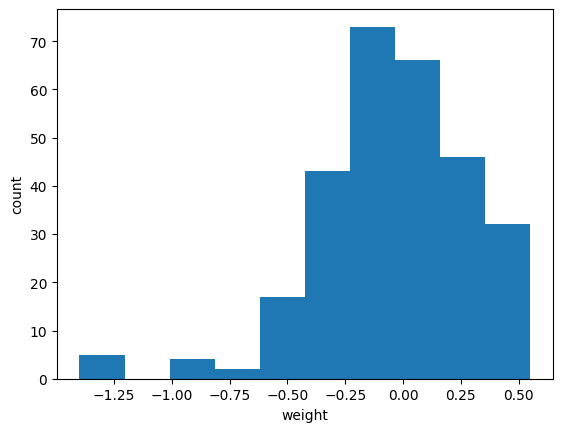

In [53]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

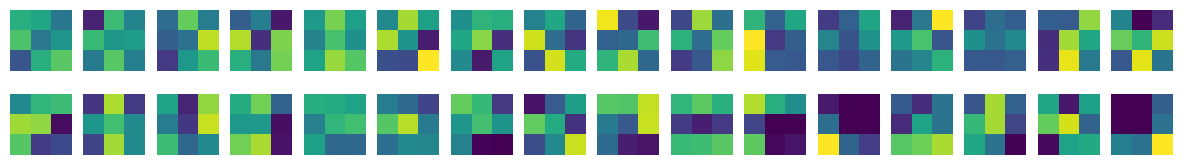

In [54]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[i*16+j,0,:,:], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

In [55]:
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
train_input = fm_train.data

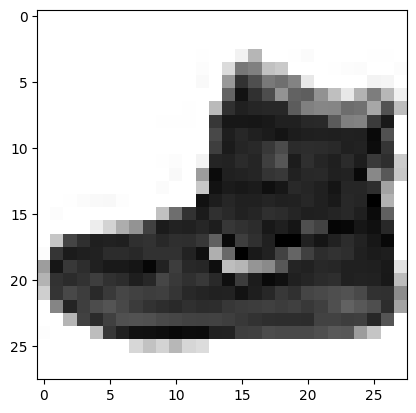

In [56]:
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [57]:
ankle_boot = train_input[0:1].reshape(1, 1, 28, 28) / 255.0

model.eval()
with torch.no_grad():
    feature_maps = model.conv1(ankle_boot)
    feature_maps = model.relu1(feature_maps)

print(feature_maps.shape)

torch.Size([1, 32, 28, 28])


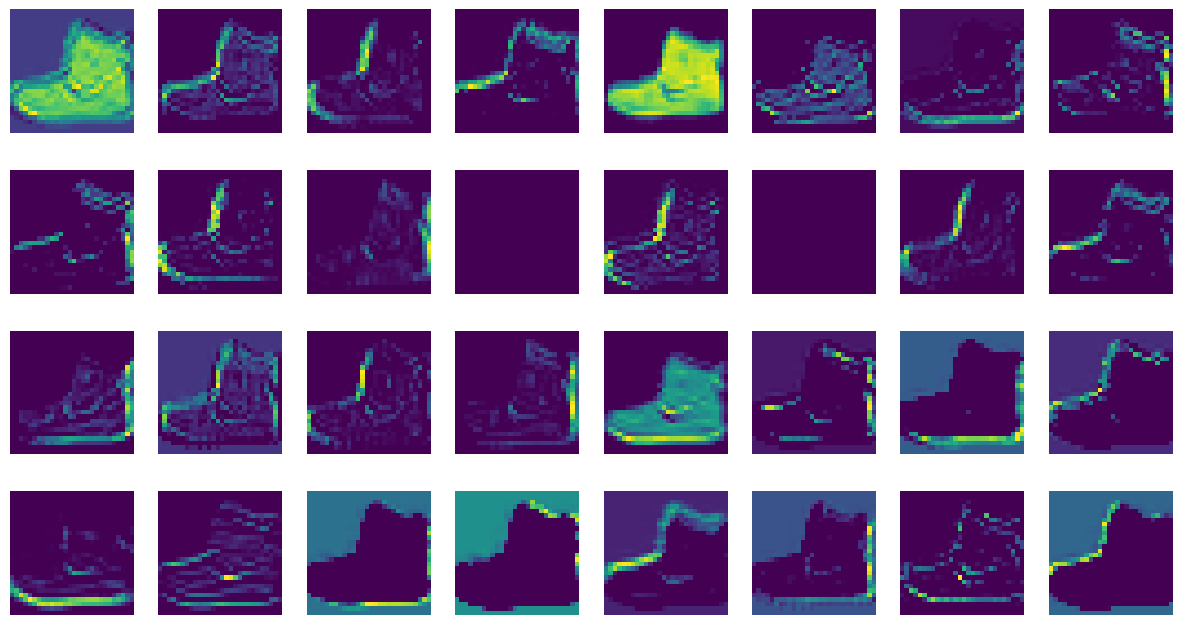

In [58]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, i*8+j,:,:])
        axs[i, j].axis('off')
plt.show()

In [59]:
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(ankle_boot)
    feature_maps = model.relu1(feature_maps)
    feature_maps = model.pool1(feature_maps)
    feature_maps = model.conv2(feature_maps)
    feature_maps = model.relu2(feature_maps)

In [60]:
model.eval()
x = ankle_boot
with torch.no_grad():
    for name, layer in model.named_children():
        x = layer(x)
        if name == 'relu2':
            break
feature_maps = x

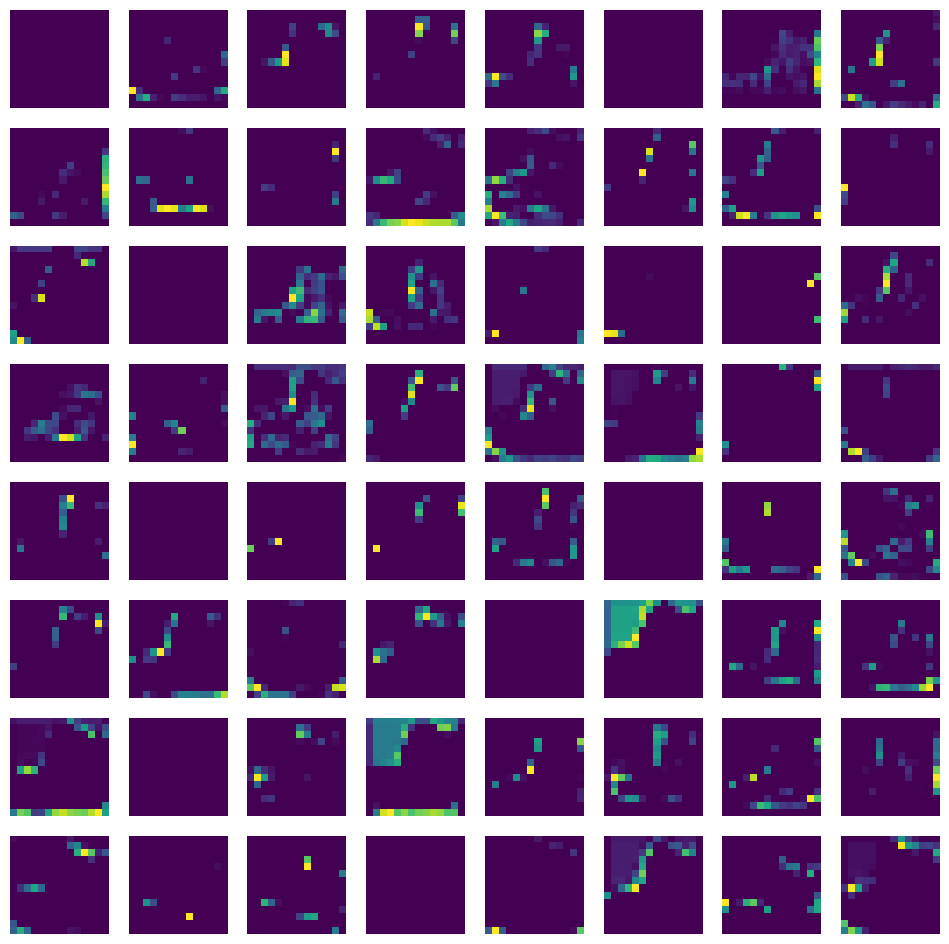

In [61]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, i*8+j,:,:])
        axs[i, j].axis('off')
plt.show()